<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/assignment_111422_classification(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06 XGBoost(eXtra GradientBoost)**
____

### | **XGBoost 개요**
___
- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나이다.
- 압도적이지는 않으나, 분류 문제에서 일반적으로 다른 머신러닝 알고리즘보다 뛰어난 예측 성능을 보인다.
- XGBoost는 GBM에 기반하고 있지만, GBM의 단점인 긴 수행 시간과 과접합 규제(Regularization) 부재 등을 해결하였다.
- 특히 XGBoost는 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습을 완료할 수 있다.
- XGBoost의 장점
  1. 뛰어난 예측 성능 : 일반적으로 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘한다.
  2. GBM 대비 빠른 수행 시간 : 일반적인 GBM은 순차적으로 Weak learner가 가중치를 증감하는 방식으로 학습하기 때문에 전반적으로 속도가 느리지만, XGBoost는 병렬 수행을 포함한 다양한 기능으로 GBM에 비해 빠른 수행 속도를 보장한다.(다만, 일반적인 GBM 외의 다른 머신러닝 알고리즘에 비해 빠르지는 않다.)
  3. 과적합 규제(Regularization) : 표준 GBM의 경우, 과적합 규제 기능이 없으나, XGBoost는 자체에 과접학 규제 기능이 있어 과적합에 좀 더 강하다.
  4. Tree pruning(나무 가지치기) : XGBoost는 `max_depth` 파라미터로도 분할 깊이를 조정하지만, tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄인다.
  5. 자체 내장된 교차 검증 : XGBoost는 반복 수행마다 내부적으로 학습 데이터셋과 평가 데이터셋에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수를 가질 수 있따. 지정된 반복 회수 이전에 교차 검증을 통해 평가 데이터셋의 평가 값이 최적화되면 반복을 중간에 멈출 수 있다.
  6. 결손값 자체 처리 : XGBoost는 결손값을 자체 처리할 수 있는 기능을 가지고 있다.
- xgboost 파이썬 패키지는 XgBoost 전용 패키지로, XGBoost 고유의 프레임워크를 파이썬 기반에서 구현한 것으로 별도의 API 기반이다. 따라서 사이킷런의 `fit()`, `predict()` 메서드와 같은 사이킷런 고유의 함수 등을 적용할 수 없었는데, 연동할 수 있는 Wrapper class가 제공되어 사이킷런과 연동할 수 있게 되었다.
  1. **파이썬 래퍼 XGBoost 모듈** : 초기의 독자적인 XGBoost 프레임워크 기반의 XGBoost. 고유의 API와 하이퍼 파라미터를 사용한다.
  2. **사이킷런 래퍼 XGBoost 모듈** : 사이킷런과 연동되는 모듈

### | **XGBoost 설치하기**
___

In [1]:
# 구글 코랩 XGBoost 설치 코드
!pip install -q xgboost==0.4a30

     |████████████████████████████████| 753 kB 5.6 MB/s 


In [2]:
# 설치되었는지 확인하기
import xgboost as xgb
from xgboost import XGBClassifier

### | **파이썬 래퍼 XGBoost 하이퍼 파라미터**
___
- XGBoost는 GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있으며, 여기에 조기 중단(early stopping), 과적합을 규제하기 위한 하이퍼 파라미터를 추가로 가지고 있다.
- 파이썬 래퍼 XGBoost 모듈과 사이킷런 래퍼 XGBoost 모듈의 일부 하이퍼 파라미터는 동일한 기능을 하는 하이퍼 파라미터지만, 사이킷런 파라미터의 Naming Rule에 따라 파라미터 명이 달라져 주의해야 한다. 

**[ 파이썬 래퍼 XGBoost 하이퍼 파라미터의 유형 ]**
1. **일반 파라미터** : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터
  - `booster` : `gbtree`(tree based model) 혹은 `gblinear`(linear model) 중 선택. 디폴트는 `gbtree`
  - `silent` : 디폴트는 0. 출력 메세지를 보이지 않고 싶을 경우, 1로 설정
  - `nthread` : CPU의 실행 스레드 개수를 조정한다. 디폴트는 CPU의 전체 스레드를 다 사용하는 것이다.
2. **부스터 파라미터** : 트리 최적화, 부스팅, regularization 등과 관련된 파라미터
  - `eta` : GBM의 학습률(lerning rate)과 같은 파라미터. 디폴트는 0.1이며 보통 0.01~0.2 사이의 값을 선호한다.
  - `num_boost_rounds` : GBM의 `n_estimators`와 같은 파라미터이다.
  - `min_child_weight` : 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weighth 총합. 값이 클수록 분할을 자제한다. 과적합을 조절하기 위해 사용한다. 디폴트는 1
  - `gamma` : 트리의 리프 노드를 추가적으로 나눌지를 결정하는 최소 손실 감소 값이다. 해당 값보다 큰 loss가 감소되면, 리프 노드를 분리한다. 값이 클수록 과적합이 감소한다. 디폴트는 0
  - `max_depth` : 트리 기반 알고리즘의 `max_depth`와 같으며, 0을 지정하면 깊이에 제한이 없다. 값이 클수록 과적합이 높아지기 때문에 보통은 3~10 사이의 값을 적용하며, 디폴트는 6
  - `sub_sample` : GBM의 `subsample`과 동일하다. 트리가 커져서 과적합되는 것을 막기 위해 데이터를 샘플링하는 비율을 지정한다. 예를 들어, `sub_sample = 0.5`로 지정하면 전체 데이터의 절반을 트리를 생성하는 데 사용한다. 디폴트는 1
  - `colsample_bytree` : GBM의 `max_features`와 유사하다. 트리 생성에 필요한 Feature를 임의로 샘플링할 때 사용한다. 매우 많은 Feature가 있을 때 과적합을 막기 위해 사용한다. 디폴트는 1
  - `lambda` : L2 Regularization 적용 값이다. Feature 개수가 많을 경우 사용하며, 값이 클수록 과적합을 감소시킨다. 디폴트는 1
  - `alpha` : L1 Regularization 적용 값이다. Feature 개수가 많을 경우 사용하며, 값이 클수록 과적합을 감소시킨다. 디폴트는 0
  - `scale_pos_weight` : 특정 값이 많아 비대칭한 클래스로 구성된 데이터셋의 균형을 유지하기 위한 파라미터이다.
3. **학습 태스크 파라미터** : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
  - `objective` : 최솟값을 가져야할 손실 함수를 정의한다.
  - `binary:logistic` : 이진 분류일 때 적용한다.
  - `multi:softmax` : 다중 분류일 때 적용한다. 손실함수가 `multi:softmax`일 경우, Label 클래스의 개수인 `num_class` 파라미터를 지정해야 한다.
  - `multi:softprob` : `multi:softmax`와 유사하나, 개별 Label 클래스의 해당되는 예측 확률을 반환한다.
  - `eval_metric` : 검증에 사용되는 함수를 정의한다. 기본값은 회귀는 rmse, 분류는 error이다.
    + `rmse` : Root Mean Square Error
    + `mae` : Mean Absolute Error
    + `logloss` : Negative log-likeligood
    + `error` : Binary classification error rate(0.5 threshold)
    + `merror` : Multiclass classification error rate
    + `mlogloss` : Multiclass log loss
    + `auc` : Area under the curve

- 뛰어난 알고리즘일수록 파라미터를 튜닝할 필요가 적으며, 튜닝에 의한 성능 향상도 미미한 편이다.
- 과적합 문제가 심각하다면
  1. `eta`값을 작게 한다.(`num_round`는 높여줘야 한다.)
  2. `max_depth` 값을 작게 한다.
  3. `min_child_weight`값을 높인다.
  4. `gamma` 값을 높인다.
  5. `subsample`과 `colsample_bytree`를 조정한다.
- XGBoost는 자체적으로 교차 검증, 성능 평가, Feature 중요도 등의 시각화 기능을 가지고 있으며, 여러 가지 성능 향상 기능 또한 보유하고 있다.
  + 조기 중단 기능(Early Stopping) : 지정한 부스팅 반복 횟수에 도달하지 않더라도, 예측 오류가 더 이상 개선되지 않으면, 반복을 끝까지 수행하지 않고 중지해 수행 시간을 개선할 수 있다.

In [3]:
# XGBoost 버전 확인
import xgboost
print(xgboost.__version__)

0.4


### | **파이썬 래퍼 XGBoost 적용-위스콘신 유방암 예측**
___
- 위스콘신 유방암 데이터셋을 활용하여 파이썬 래퍼 XGBoost API의 사용법을 살펴보자.
- **XGBoost**는 자체적으로 교차 검증, 성능 평가, Feature 중요도 등의 시각화 기능을 가지고 있다. 또한 조기 중단 기능(Early Stopping)을 보유하여, 지정한 부스팅 반복 횟수에 도달하지 않더라도, 예측 오류가 더 이상 개선되지 않으면, 반복을 끝까지 수행하지 않고 중지해 수행 시간을 개선할 수 있다.
- **위스콘신 유방암 데이터셋**은 종양의 크기, 모양 등의 다양한 Feature를 기반으로 종양이 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 정이되어 생명을 위협하는 **악성 종양(malignant)**인지, 비교적 성장 속도가 느리고 전이되지 않는 **양성 종양(benign)**인지를 **분류**한 데이터셋이다.
- `plot_importance` : xgboost 패키지에서 Feature의 중요도를 시각화해주는 모듈

In [4]:
# import package
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# load data
dataset = load_breast_cancer()

# feature/label 분리
X_features= dataset.data
y_label = dataset.target

# DAtaFrame으로 변환
cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names) # column 명은 dataset의 feature_names을 참고해 설정
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


- 종양의 크기와 모양에 관련된 Feature들이 숫자형 값으로 되어 있다.
- Label 값은 악성인 'malignant'는 0으로, 양성인 'benign'은 1로 되어있다.

In [5]:
# Label 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


- 파이썬 래퍼 XGBoost는 학습/테스트 데이터셋을 별도의 객체인 DMatrix로 생성한다.
- DMatrix는 주로 Numpy 형을 입력 파라미터로 받아서 만들어지는 XGBoost만의 전용 데이터셋으로, 주요 입력 파라미터는 `data`와 `label`이다.
  1. `data` : Feature 데이터셋
  2. `label` : 분류의 경우, Label 데이터셋. 회귀의 경우, 숫자형인 종속값 데이터셋

In [7]:
# Numpy 형태의 학습/테스트 데이터셋을 DMatrix로 변환하는 코드
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [8]:
# XGBoost의 하이퍼 파라미터 : 주로 딕셔너리 형태로 입력
# 트리 최대 깊이, 학습률, objective 함수, 오류 함수, 부스팅 반복 횟수 설정
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

- 조기 중단은 xgboost의 `train()` 함수에 `early_stopping_rounds` 파라미터를 입력하여 설정한다. 이를 설정할 때는 반드시 `eval_set`과 `eval_metric`을 함께 설정해야 한다.
  1. `eval_set` : 성능 평가를 수행할 평가용 데이터셋을 설정
  2. `eval_metric` : 평가 세트에 적용할 성능 평가 방법을 설정하며, 분류일 경우 주로 `error`(분류 오류)나 `logloss`를 적용한다.
- `train()` 함수는 학습이 완료된 모델 객체를 반환한다.

In [9]:
# train 데이터셋은 'train', evaluation(test) 데이터셋은 'eval'로 명기합니다
wlist = [(dtrain,'train'),(dtest,'eval') ]

# 하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain = dtrain , num_boost_round = num_rounds , early_stopping_rounds = 100, evals = wlist )

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-logloss:0.609688	eval-logloss:0.613520
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.390550	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.297210
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.220050
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.143330	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729


- `train()`으로 학습을 수행하면, 반복 시 train-error와 eval-logloss가 지속적으로 감소한다.
- xgboost를 이용해 모델의 학습이 완료되었다. 이를 이용해 테스트 데이터셋에 예측을 수행해보자.
- 파이썬 래퍼 XGBoost는 `train()` 함수를 호출해 학습이 완료된 모델 객체를 반환하는데, 이 객체는 예측을 위해 `predict()` 메서드를 사용한다. 다만 사이킷런의 `predict()` 메서드는 예측 결과 클래스 값(0 혹은 1)을 반환하지만, xgboost의 `predict()` 메서드는 예측 결과를 추정할 수 있는 확률 값을 반환한다는 점을 유의해야 한다.
- 본 예제에서는 암이 악성인지, 양성인지를 판단하는 이진 분류이므로, 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정하는 코드를 추가해보자.

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[ : 10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.003 0.896 0.073 0.993 1.    1.    0.999 0.996 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


- 3장에서 만든 `get_clf_eval()` 함수를 적용해 XGBoost 모델의 예측 성능을 평가해보자.

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [12]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


- 정확도는 약 0.9737, 정밀도는 0.9744, 재현율은 0.9870, F1-스코어는 0.9806, 그리고 ROC-AUC는 0.9951으로 측정되었다.
- 이번에는 xgboost 패키지에 내장된 시각화 기능을 사용해보자.
- xgboost의 `plot_importance()` API는 Feature의 중요도를 기본 평가 지표로 F1 스코어를 사용하여, 막대 그래프 형식으로 나타낸다. 다만 xgboost 넘파이 기반의 Feature 데이터로, Feature 명을 제대로 알 수 없어 f0, f1과 같이 Feature 순서별로 f자 뒤에 순서를 붙여 X축에 Feature를 나열한다는 점에 유의해야 한다.

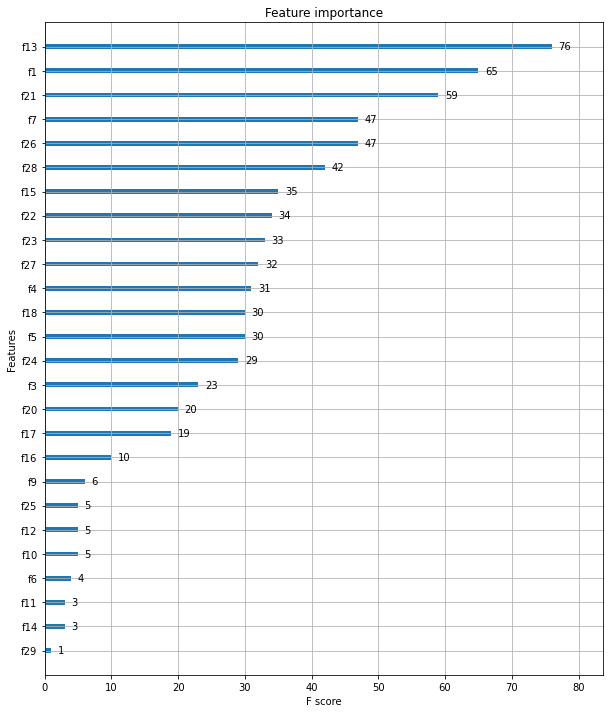

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

- 결정 트리에서 본 트리 기반 규칙 구조도 xgboost에서 `to_graphviz()` API를 이용하여, 시각화 할 수 있다. 단, Graphviz 프로그램과 패키지가 설치되어 있어야 한다.
- 파이썬 래퍼 XGBoost의 `cv()` API : 데이터셋에 대한 교차 검증을 수행한 후 최적 파라미터를 구할 수 있는 API. 반환값은 DataFrame 형태이다.

### | **사이킷런 래퍼 XGBoost의 개요 및 적용**
___
- **사이킷런 래퍼 XGBoost** : 사이킷런의 프레임워크와 연동하기 위해 개발한 사이킷런 전용의 XGBoost 래퍼 클래스
- 사이킷런의 기본 Estimator를 그대로 상속해 만들었기 때문에, `fit()`과 `predict()`만으로 학습과 예측이 가능하며, GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용할 수 있다.
- 분류를 위한 래퍼 클래스인 XGBClassifier, 회귀를 위한 래퍼 클래스인 XGBRegressor가 있다.
- 파이썬 래퍼 XGBoost의 하이퍼 파라미터 중 일부는 사이킷런 래퍼 XGBoost에서 아래와 같이 변경되었다.
  1. `eta` -> `learning_rate`
  2. `sub_sample` -> `subsample`
  3. `lambda` -> `reg_lambda`
  4. `alpha` -> `reg_alpha`
- xgboost의 `n_estimators`와 `num_boost_round`는 동일한 하이퍼 파라미터인데, 파이썬 래퍼 XGBoost에서는 `num_boost_round`을 적용하고, 사이킷런 래퍼 XGBoost에서는 n_estimators`을 적용한다.
- 위스콘신 대학병원의 유방암 데이터셋에 XGBClassifier를 적용하여 예측을 해보자.
  + `n_estimators = 400`, `learning_rate = 0.1`, `max_depth = 3`으로 설정한다.
  + 위에서 사용한 학습/테스트용 데이터셋을 활용한다.

In [14]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier Import
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [15]:
# Model Test
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9954


- 파이썬 래퍼 XGBoost와 동일한 평가 결과가 나온다.
- 사이킷런 래퍼 XGBoost에서도 조기 중단을 수행할 수 있는데, 아래와 같은 파라미터를 `fit()` 안에 입력하면 된다.
  1. `early_stopping+rounds` : 평가 지표가 향상될 수 있는 반복 횟수를 정의
  2. `eval_metric` : 조기 중단을 위한 평가 지표
  3. `eval_set` : 성능 평가를 수행할 데이터셋. 학습 데이터가 아닌 별도의 데이터셋이어야 한다.
- `early_stopping_rounds = 100`, `eval_metric = "logloss"`, `eval_set = evals`로 설정하여, 조기 중단을 수행해보자.
  + `eval_set`을 테스트용 데이터로 설정하면, 테스트 데이터에 과적합이 될 수 있기 때문에 다른 데이터셋을 사용하는 게 좋다.
  + 다만 본 예제에서는 데이터셋의 크기가 작아 테스트 데이터를 평가용으로 사용했다.

In [16]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

# 테스트 데이터셋
evals = [(X_test, y_test)]

# 조기 중단 설정
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)

# 예측
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

Will train until validation_0 error hasn't decreased in 100 rounds.
[0]	validation_0-logloss:0.613520
[1]	validation_0-logloss:0.547843
[2]	validation_0-logloss:0.494248
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.297210
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.220050
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154432
[22]	validation_0-logloss:0.148656
[23]	validation_0-logloss:0.141245
[24]	validation_0-logloss:0.136042
[25]	validation_0-logloss:0.132487
[26]	validation_0-logloss:0.1276

- `n_estimators`를 400에서 설정했으나, 311번 반복 후 학습을 완료했음을 알 수 있다. 211번 반복에서 `logloss`가 0.085593이었는데, 100번(`early_stopping_rounds=100`)의 반복 후 311번 반복의 `logloss`가 0.085948로 성능 평가 지수가 향상되지 않았기 때문에 반복하지 않고 종료한 것이다.

In [17]:
# Model Test
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


- 위에서는 예측 성능이 조기 중단이 적용되지 않은 결과보다 약간 저조한 성능을 보이고 있다. 다만 조기 중단값을 너무 급격하게 줄이면 충분한 학습이 되지 않아 예측 성능이 크게 저하될 수 있다.
- `early_stopping_rounds = 10`으로 설정해 예측 성능을 측정해보자.

In [18]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = "logloss", eval_set = evals,verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# Model Test
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9944


Will train until validation_0 error hasn't decreased in 10 rounds.
[0]	validation_0-logloss:0.613520
[1]	validation_0-logloss:0.547843
[2]	validation_0-logloss:0.494248
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.297210
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.220050
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154432
[22]	validation_0-logloss:0.148656
[23]	validation_0-logloss:0.141245
[24]	validation_0-logloss:0.136042
[25]	validation_0-logloss:0.132487
[26]	validation_0-logloss:0.12763

- 정확도가 0.9561로 위의 0.9649보다 낮다.
- Feature의 중요도를 시각화하는 모듈인 `plot_importance()` API에 사이킷런 래퍼 클래스를 입력해도 앞에서 파이썬 래퍼 클래스를 입력한 결과와 똑같이 시각화 결과를 출력한다.

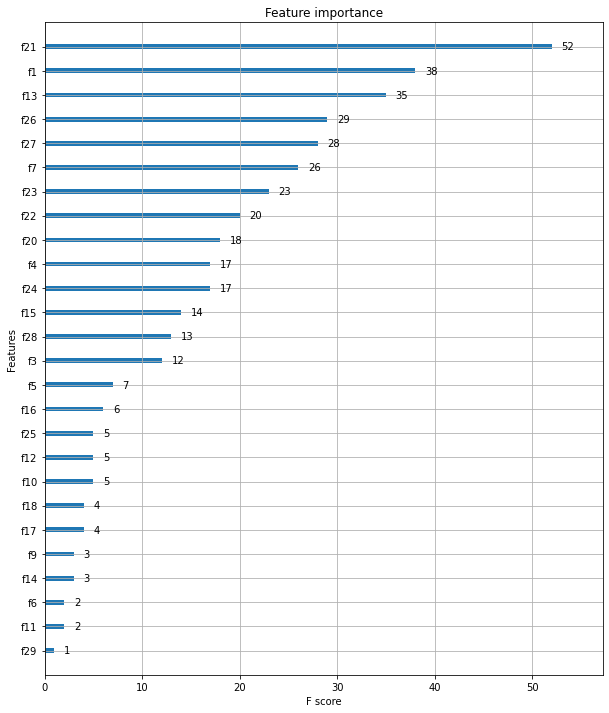

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)

## **07 LightGBM**
____
- XGBoost는 매우 뛰어난 부스팅 알고리즘이지만, 여전히 학습 시간이 길다. GridSearchCV로 하이퍼 파라미터 튜닝을 수행하다 보면 수행 시간이 너무 오래 걸려, 많은 파라미터를 튜닝할 수 없다.
- LightGBM의 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 훨씬 적다는 것이다. 또한 메모리 사용량도 상대적으로 적다. 또한 예측 성능은 XGBoost와 별다른 차이가 없다. 
- 일반 GBM 계열이 균형 트리 분할 방식(Level Wise)을 사용하지만, **LightGBM은  Leaf 중심 트리 분할 방식(Leaf Wise)**을 사용한다.
  - 균형 트리 분할 방식(Level Wise) : 최대한 균형 잡힌 트리를 유지하기 위해 분할하기 때문에 트리의 깊이가 최소화된다. 다만, 균형을 맞추기 위해 시간이 필요하다.
  - Leaf 중심 트리 분할 방식(Leaf Wise) : 트리의 균형을 맞추지 않고, 최대 손실값(max delta loss)을 가지는 리프 노드를 계속 분할한다. 이에 따라 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다. 하지만, 예측 오류 손실을 최소화할 수 있다.
-  LightGBM의 XGBoost 대비 장점
  1. 더 빠른 학습과 예측 수행 시간
  2. 더 작은 메모리 사용량
  3. 범주형 Feature의 자동 변환과 최적 분할(원-핫 인코딩 등을 적용하지 않아도, 범주형 Feature를 최적으로 변환하고 이를 이용하여 노드 분할을 수행)
-  LightGBM의 파이썬 패키지 명은 `lightgbm`이다. XGBoost와 마찬가지로 초기에는 파이썬 래퍼용  LightGBM만 개발되었으나, 이후에 사이킷런과 호환 가능한 사이킷런 래퍼  LightGBM가 추가로 개발되었다.
-  사이킷런 래퍼 LightGBM 클래스는 분류를 위한 `LGBMClassifier`와 회귀를 위한 `LGBMRegressor` 클래스가 있다.
  + 사이킷런 기반의 Estimator을 상속 받았기 때문에, `fit()`, `predict()` 기반의 학습 및 예측과 사이킷런이 제공하는 다양한 유틸리티를 활용할 수 있다.

### | **LightGBM 설치**
___

In [20]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### | **LightGBM 하이퍼 파라미터**
___
##### **[ 주요 파라미터 ]**
1. **`num_iterations`(default = 100)** : 반복 수행하려는 트리의 개수를 지정한다. 크게 지정할수록 예측 성능은 높아지나, 과적합으로 인해 성능이 저하될 수 있다. 사이킷런 호환 클래스에서는 `n_estimators`로 이름이 변경된다.
2. **`learning_rate`(default = 0.1)** : 0과 1 사이의 값으로, 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값이다. 일반적으로 `n_estimators`을 크게 하고 `learning_rate`을 작게 하여 예측을 성능을 향상시킬 수 있으나, 과적합 문제와 학습 시간이 길어질 수 있다는 점을 유의해야 한다.
3. **`max_depth`(default = 1)** : 트리 기반 알고리즘의 `max_depth`와 같은 하이퍼 파라미터이다. 0보다 작은 값을 지정하면 깊이에 제한이 없다. LightGBM은 Leaf Wise 기반이므로 깊이가 Depth wise 방식의 트리보다 상대적으로 더 깊다.
4. **`min_data_in_leaf`(default = 20)** : 결정 트리의 `min_samples_leaf`와 같은 파라미터로 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수이다. 과적합을 제어한다. 사이킷런 래퍼 LightGBM 클래스에서는 `min_child_samples`로 이름이 다르다.
5. **`num_leaves`(default = 31)** : 하나의 트리가 가질 수 있는 최대 리프 개수
6. **`boosting(default = gbdt)** : 부스팅의 트리를 생성하는 알고리즘을 설정한다. `gbdt`는 일반적인 그래디언트 부스팅 결정 트리이고, `rf`는 랜덤 포레스트를 의미한다.
7. **`baggin_fraction`(default = 1.0)** : 트리가 커져 과적합되는 것을 막기 위해 데이터를 샘플링하는 비율을 지정한다. 사이킷런 래퍼 LightGBM에서는 `subsample`로 이름이 변경된다.
8. **`feature_fraction`(default = 1.0)** : 개별 트리를 학습할 때마다 무작위로 선택하는 Feature의 비율로 과적합을 막기 위한 파라미터이다. 사이킷런 래퍼 LightGBM에서는 `colsample_bytree`로 이름이 변경된다.
9. **`lambda_l2`(default = 0.0)** : L2 Regulation 제어를 위한 값이다. Feature의 개수가 많을 때 적용하며, 값이 클수록 과적합 감소 효과가 있다. 사이킷런 래퍼 LightGBM에서는 `reg_lambda`로 이름이 변경된다.
10. **`lambda_l1`(default = 0.0)** : L1 Regulation 제어를 위한 값이며, 과적합 감소 효과가 있다. 사이킷런 래퍼 LightGBM에서는 `reg_alpha`로 이름이 변경된다.


##### **[ Learning Task 파라미터 ]**
- **`objective`** : 최솟값을 가져야 할 손실 함수를 정의한다. 회귀, 다중 클래스 분류, 이진 분류인지에 따라 지정된다. 

### | **하이퍼 파라미터 튜닝 방안**
___
- `num_leaves`의 개수를 중심으로 `min_child_samples`(`min_data_in_leaf`), `max_depth`를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본적인 튜닝 방법이다.
  - `num_leaves`는 개별 트리가 가질 수 있는 최대 리프 개수로 LightGBM 모델의 복잡도를 제어하는 주요 파라미터이다. `num_leaves`의 개수가 많아지면, 정확도가 높아지지만, 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 가능성도 커진다.
  - `min_child_samples`(`min_data_in_leaf`)는 과적합을 개선하기 위해 중요한 파라미터이다. `num_leaves`와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.
  - `max_depth`은 명시적으로 깊이의 크기를 제한해 과적합을 개선한다.
- `n_estimators`을 크게 하고 `learning_rate`을 작게 하는 것도 기본적인 튜닝 방안 중 하나이다. 다만 `n_estimators`를 너무 크게 하면 과적합될 수 있다.
- 이밖에도 과적합을 막기 위해, 
  1. `reg_lambda`, `reg_alpha`와 같은 regularization을 적용하거나
  2. 학습 데이터에 사용할 Feature 개수, 데이터 샘플링 레코드 개수를 줄이기 위해 `colsample_bytree`, `subsample` 파라미터를 활용할 수 있다.

### | **파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교**
___


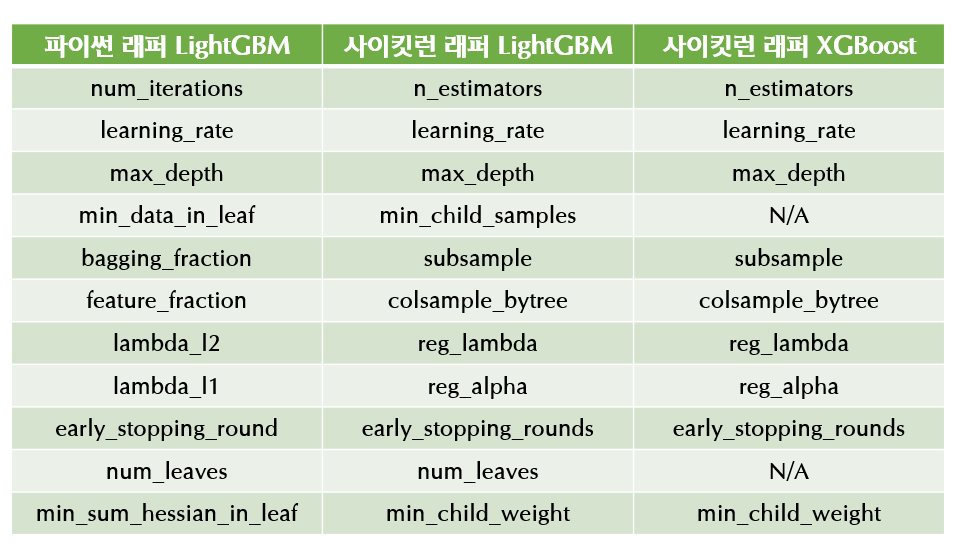

### | **LigthGBM 적용-위스콘신 유방암 예측**
___
- 앞서 XGBoost에서 사용한 위스콘신 유방암 데이터셋을 이용해 LightGBM으로 예측해보자.
- LightGBM의 파이썬 패키지에서 `lightgbm`에서 `LGBMClassifier`를 import해 사용한다.
- LightGBM도 `fit()` 함수에 조기 중단 관련 파라미터를 설정하면, 조기 중단 기능(early stopping) 기능을 사용할 수 있다.

In [21]:
# LightGBM 버전 확인
import lightgbm
print(lightgbm.__version__)

2.2.3


In [22]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier Import
from lightgbm import LGBMClassifier

# import package
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# load data
dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size = 0.2, random_state = 156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400으로 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [23]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,    F1: 0.9615, AUC:0.9926


- 정확도가 약 94.74%로 앞 예제의 XGBoost의 정확도(약 96.49%)보다는 작다. 다만 본 예제의 경우, 학습 데이터셋과 테스트 데이터셋의 크기가 작아 알고리즘 간 성능 비교는 큰 의미가 없다.
- LightGBM 파이썬 패키지인 `lightgbm`은 XGBoost 파이썬 패키지인 `xgboost`와 동일하게 Feature의 중요도를 시각화할 수 있는 내장 API로 `plot_importance()`를 제공한다.

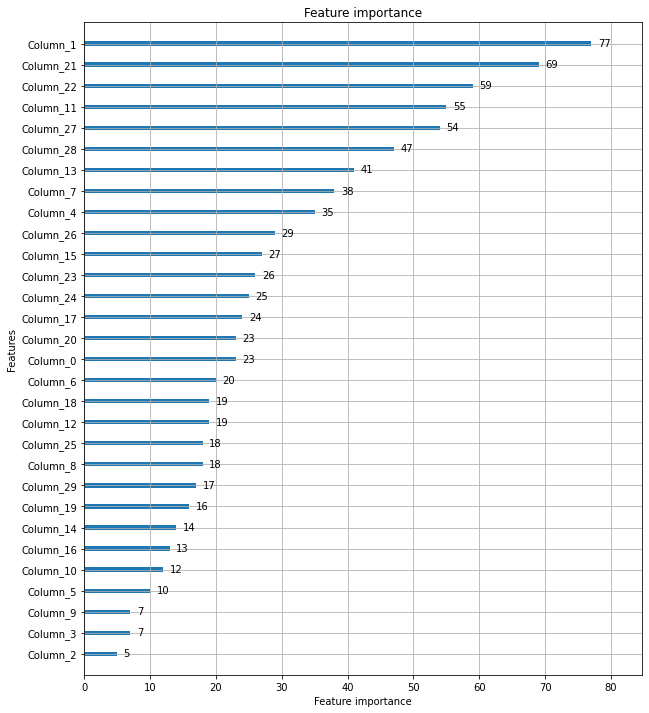

In [24]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)

## **10 스태킹 앙상블**
____
- 스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 앞서 소개한 Bagging, Boosting과 비슷하다. 다만 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점에서 차이가 있다.
- 즉, Stacking은 개별 알고리즘의 예측 결과 데이터셋을 최종적인 메타 데이터셋으로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식이다.(이런 방식을 메타 모델이라고 한다.)
- 스태킹 모델은 두 종류의 모델이 필요하다. 첫 번째는 개별적인 기반 모델이고, 두 번째는 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어 학습하는 최종 메타 모델이다.
- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 Feature 데이터셋과 테스트용 Feature 데이터셋을 만드는 것이다.
- 스태킹을 적용할 때는 많은 개별 모델이 필요하다. 2~3개의 개별 모델만으로는 쉽게 예측 성능을 향상시킬 수 없으며, 스태킹을 적용한다고 해서 반드시 성능이 향상되는 것도 아니다.

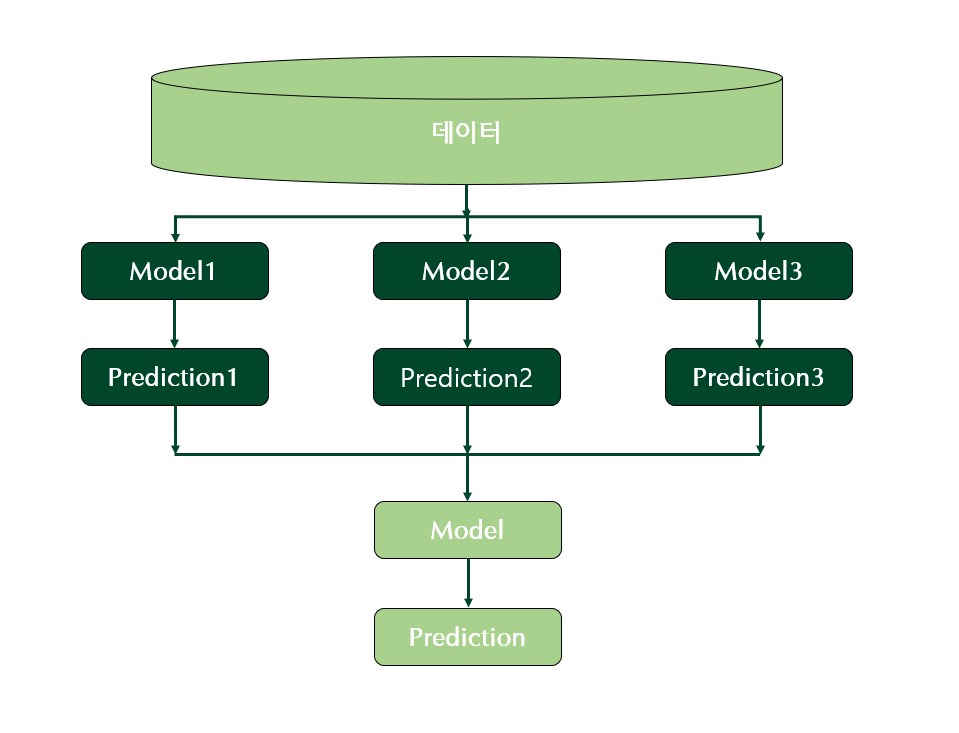

- M개의 row, N개의 Feature(Column)을 가진 데이터셋에 스태킹 앙상블을 적용한다고 가정하자. 학습에 사용할 ML 알고리즘 모델은 모두 3개이다.
  1. 먼저 모델별로 각각 학습을 시킨 뒤 예측을 수행하면 각각 M개의 Row를 가진 1개의 Label 값을 도출한다.
  2. 모델 별로 도출된 예측 Label 값을 다시 합해서(스태킹) 새로운 데이터셋을 만든다.
  3. 이렇게 스태킹된 데이터셋에 대해 최종 모델을 적용해 최종 예측을 한다.

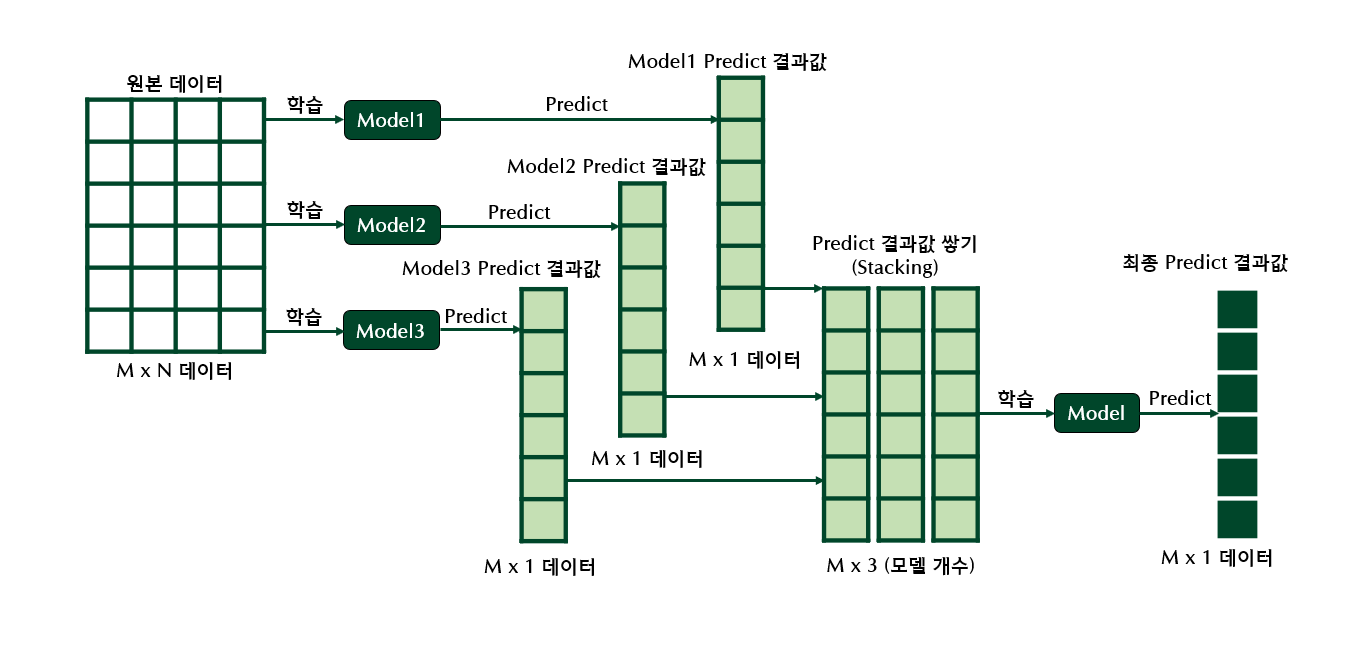

### | **기본 스태킹 모델**
___

In [25]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 위스콘신 암 데이터셋 로딩
cancer_data = load_breast_cancer()

# Feature/Label 분리
X_data = cancer_data.data
y_label = cancer_data.target

# 학습/테스트 분리
X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size = 0.2 , random_state = 0)

- 스태킹에 사용될 머신러닝 알고리즘 클래스를 생성한다.
- 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트이며, 최종 모델은 로지스틱 회귀이다.

In [26]:
# 개별 ML 모델을 위한 Classifier 생성
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier 생성
lr_final = LogisticRegression(C=10)

- 모델 학습

In [27]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

- 개별 모델의 예측 데이터셋을 반환하고 각 모델의 예측 정확도를 살펴본다.

In [28]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

# 개별 모델의 정확도 측정
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


- 개별 알고리즘으로부터 반환된 예측값을 Column 레벨로 옆으로 붙어 Feature 값으로 만든 후, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용해보자.

In [29]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. Column 레벨로 각 알고리즘의 예측 결과를 Feature로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


- 예측 데이터로 생성된 데이터셋을 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도를 측정해보자.

In [30]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


- 개별 모델의 예측 데이터를 스태킹으로 재구성해 최종 메타 모델에서 학습하고 예측한 결과, 정확도가 97.37%로 개별 모델 정확도보다 향상되었다. 다만 스태킹 기법으로 예측을 한다고 이렇게 무조건 개별 모델보다는 좋아진다는 보장은 없다.

### | **CV 세트 기반의 스태킹**
___
- CV 세트 기반의 스태킹은 과적합을 개선하기 위한 모델로, 최종 메타 모델을 위한 데이터셋을 만들 때 교차 검증을 기반으로 예측된 결과 데이터셋을 이용한다.
  - Step1 : 각 모델 별로 원본 학습/테스트 데이터를 예측한 결과를 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성한다.
    1. 학습용 데이터를 N개의 폴드(Fold)로 나눈다. 여기서는 3개의 폴드세트로 가정한다.
    2. 2개의 폴드는 학습을 위한 데이터 폴드로, 나머지 1개의 폴드는 검증을 위한 데이터 폴드로 나눈다. 
    3. 이렇게 두 개의 폴드로 나뉜 학습 데이터를 기반으로 개별 모델을 학습시키고, 1개의 검증 데이터 폴드로 예측하고 그 결과를 저장한다.
    4. 이 Logic을 학습 데이터와 검증 데이터를 변경해가며 3번 반복한다.
    5. 2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값을 생성하고, 이를 3번 반복하며 이 예측값의 평균으로 최종 결과값을 생성한다. 이 최종 결과값은 메타모델을 위한 테스트 데이터로 사용한다.
  - Step2
    1. 앞에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터셋을 생성한다.
    2. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐 메타 모델이 예측할 최종 테스트 데이터셋을 생성한다.
    3. 메타 모델은 최종적으로 생성된 학습 데이터셋과 원본 학습 데이터의 Label 데이터를 기반으로 학습한다.
    4. 최종적으로 생성된 테스트 데이터셋을 예측하고, 원본 테스트 데이터의 Label 데이터를 기반으로 평가한다.

- Step1 부분을 코드로 구현해보자.
- `get_stacking_base_datasets()` 함수 
  1. 개별 모델의 Classifier 객체, 원본 학습용 Feature 데이터, 원본 학습용 Label 데이터, 원본 테스트 Feature 데이터, K 폴드를 몇 개로 할지를 파라미터로 입력받는다.
  2. 함수 내에서는 폴드의 개수만큼 반복을 수행하며 폴드된 학습용 데이터로 학습한 뒤, 예측 결과값을 기반으로 메타 모델을 위한 학습용 데이터와 테스트용 데이터를 새롭게 생성한다.

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle = True, random_state=0)

    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr , y_tr)       
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

- 이제 여러 개의 분류 모델별로 `get_stacking_base_datasets()` 함수를 호출해 각각 메타 모델이 추후에 사용할 학습용/테스트용 데이터셋을 반환한다.

In [32]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


- 이제 Step2를 구현해보자.
- `get_stacking_base_datasets()`로 반환된 각 모델별 학습 데이터와 테스트 데이터를 넘파이의 `concatenate()`를 이용해 합친다.

In [33]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


- 이렇게 만들어진 `Stack_final_X_train`은 메타 모델이 학습할 학습용 Feature 데이터셋이다.
- `Stack_final_X_test`은 메타 모델이 예측할 테스트용 Feature 데이터셋이다.
- 스태킹 학습 FEature 데이터는 원본 학습 Feature 데이터와 Row 크기가 같으며, Column 크기는 4개의 개별 모델의 예측값을 합친 것이기 때문에 4이다.
- 최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 Feature 데이터셋과 원본 학습 Label 데이터로 학습한 후, 스태킹된 테스트 데이터셋으로 예측하고, 예측 결과를 원본 테스트 Label 데이터와 빅해 정확도를 측정해보자.

In [34]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9649


- 최종 모델의 예측 정확도는 약 96.49%이다.
- 스태킹을 이루는 모델은 최적으로 파라미터를 튜닝한 상태에서 스태킹 모델을 만드는 것이 일반적이다.
- 일반적으로 스태킹 모델의 파라미터 튜닝이란 개별 알고리즘 모델의 파라미터를 최적으로 튜닝하는 것을 말한다.

## **11 정리**
____
- 이번 장에서는 분류를 위해 일반적으로 가장 많이 사용되는 앙상블에 대해 집중적으로 공부했다.
- 대부분의 앙상블 기법은 결정 트리 기반으로 여러 개의 약한 학습기(Weak Learner)를 결합해 변동성을 줄여 예측 오류를 줄이고, 성능을 개선한다.
- 결정 트리 알고리즘은 정보의 균일도에 기반하여 규칙 트리를 만들어 예측을 수행하며, 다른 알고리즘에 비해 비교적 짖관적이어서 예측 결과가 도출되는 과정을 쉽게 알 수 있다. 다만 균일한 최종 예측 결과를 도출하기 위해 결정 트리가 깊어지고 복잡해져 과적합이 쉽게 발생한다는 것이 단점이다.
- 앙상블 기법은 대표적으로 Bagging과 Boosting으로 구분될 수 있다.
  1. Bagging 방식은 학습 데이터의 중복을 허용하여 다수의 세트로 샘플링한 후, 이를 여러 개의 약한 학습기가 학습한 뒤, 최종 결과를 결합해 예측하는 방식이다. 대표적인 Bagging 방식으로는 랜덤 포레스트가 있다.
  2. Boosting 방식은 학습기들이 순차적으로 학습을 진행하며 예측이 틀린 데이터에 대해 가중치를 부여한 후, 다음 번 학습기가 학습할 때는 이전에 예측이 틀린 데이터에 대해 보다 높은 정확도로 예측할 수 있게 한다. 대표적인 Boosting 방식인 GBM은 뛰어난 예측 성능을 가졌지만, 수행시간이 너무 오래 걸렸고, 이를 개선하기 위해 XGBoost와 LightBGM이 개발되었다.
- 마지막으로 스태킹 모델을 살펴보았는데, 스태킹은 여러 개의 개별 모델이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터셋과 예측할 테스트 데이터셋을 재생성하는 기법이다.